## Live drift correction
- We got shift in x and y from section before - using drift_correct_1.ipynb
- we find out the pixel size from the metadata of the images
- we compute distance in m/nm to move 
- we shift the beam to that delta disance in x and y
#### Contributor(s): Utkarsh Pratiush <utkarshp1161@gmail.com> - 26th March 2025
#### edited - 
   

In [24]:
from stemOrchestrator.acquisition import TFacquisition
from stemOrchestrator.process import HAADF_tiff_to_png
from autoscript_tem_microscope_client import TemMicroscopeClient
import logging
from stemOrchestrator.logging_config   import setup_logging
import matplotlib.pyplot as plt
plot = plt

from typing import Dict

## 1. Connect to microscope

In [25]:
import os
import json
from pathlib import Path

ip = os.getenv("MICROSCOPE_IP")
port = os.getenv("MICROSCOPE_PORT")

if not ip or not port:
    secret_path = Path("../../config_secret.json")
    if secret_path.exists():
        with open(secret_path, "r") as f:
            secret = json.load(f)
            ip = ip or secret.get("ip")
            port = port or secret.get("port")

if not ip:
    ip = input("Enter microscope IP: ")
if not port:
    port = input("Enter microscope Port: ")

try:
    port = int(port)
except ValueError:
    raise ValueError("Port must be an integer")

config = {
    "ip": ip,
    "port": port,
    "haadf_exposure": 40e-8,  # micro-seconds per pixel
    "out_path": "."
}

## 2. Intialize microscope

In [26]:
data_folder  = "../../data/"
out_path = data_folder 

In [27]:

ip = config["ip"]
port = config["port"]
haadf_exposure = config["haadf_exposure"]
out_path = config["out_path"]

setup_logging(out_path=out_path)

microscope = TemMicroscopeClient()
microscope.connect(ip, port = port)# 7521 on velox  computer

# query state:

tf_acquisition = TFacquisition(microscope=microscope)



2025-03-26 16:24:50,675 - INFO - Starting microscope initialization...
2025-03-26 16:24:50,676 - INFO - LOGGING STATE of the Microscope================================================
2025-03-26 16:24:50,677 - INFO - Request to log the state of the microscope
2025-03-26 16:24:50,677 - INFO - Request to query the list of detectors on the Scope
2025-03-26 16:24:50,682 - INFO - DONE: querying the list of detectors: ['BM-Ceta', 'BM-Falcon', 'Flucam', 'BM-Empad'] 
2025-03-26 16:24:50,683 - INFO - Request: Checking for vacuum valves -- current status
2025-03-26 16:24:50,689 - INFO - DONE: Checking for vacuum valves -- current status: Opened
2025-03-26 16:24:50,694 - INFO - Query beam position: which is at Point(x=1, y=1)
2025-03-26 16:24:50,700 - INFO - Checking for beam blanked or not -- current status: True
2025-03-26 16:24:50,702 - INFO - Request to query the optical mode of the instrument
2025-03-26 16:24:50,708 - INFO - DONE: the optical mde of the microsocpe is Tem
2025-03-26 16:24:50,

Client connecting to [10.46.217.242:9090]...
Client connected to [10.46.217.242:9090]


## 3. Acquire 2 images to compute drift

2025-03-26 16:24:53,383 - INFO - Acquiring HAADF image.
2025-03-26 16:24:53,516 - INFO - saving HAADF image as TF which has all the metadata..also returning an array


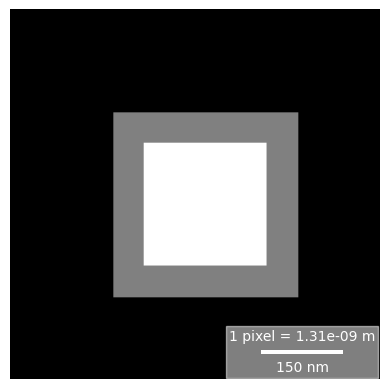

2025-03-26 16:24:53,566 - INFO - END acquisition.
2025-03-26 16:24:53,567 - INFO - Acquiring HAADF image.
2025-03-26 16:24:53,665 - INFO - saving HAADF image as TF which has all the metadata..also returning an array


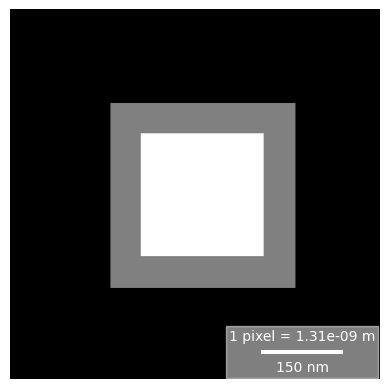

2025-03-26 16:24:53,710 - INFO - END acquisition.


In [28]:
# get image 1 for drift
haadf_np_array_old, haadf_tiff_name, pixel_size_tuple = tf_acquisition.acquire_haadf(exposure = 1e-5, return_pixel_size=True)
HAADF_tiff_to_png(haadf_tiff_name)

logging.info("END acquisition.")

# get image 2 for drift
haadf_np_array_new, haadf_tiff_name, pixel_size_tuple = tf_acquisition.acquire_haadf(exposure = 1e-5, return_pixel_size=True)
HAADF_tiff_to_png(haadf_tiff_name)

logging.info("END acquisition.")

## 4. compute drift - as shown in the notebook : drift_correct_offline

4.0 13.0


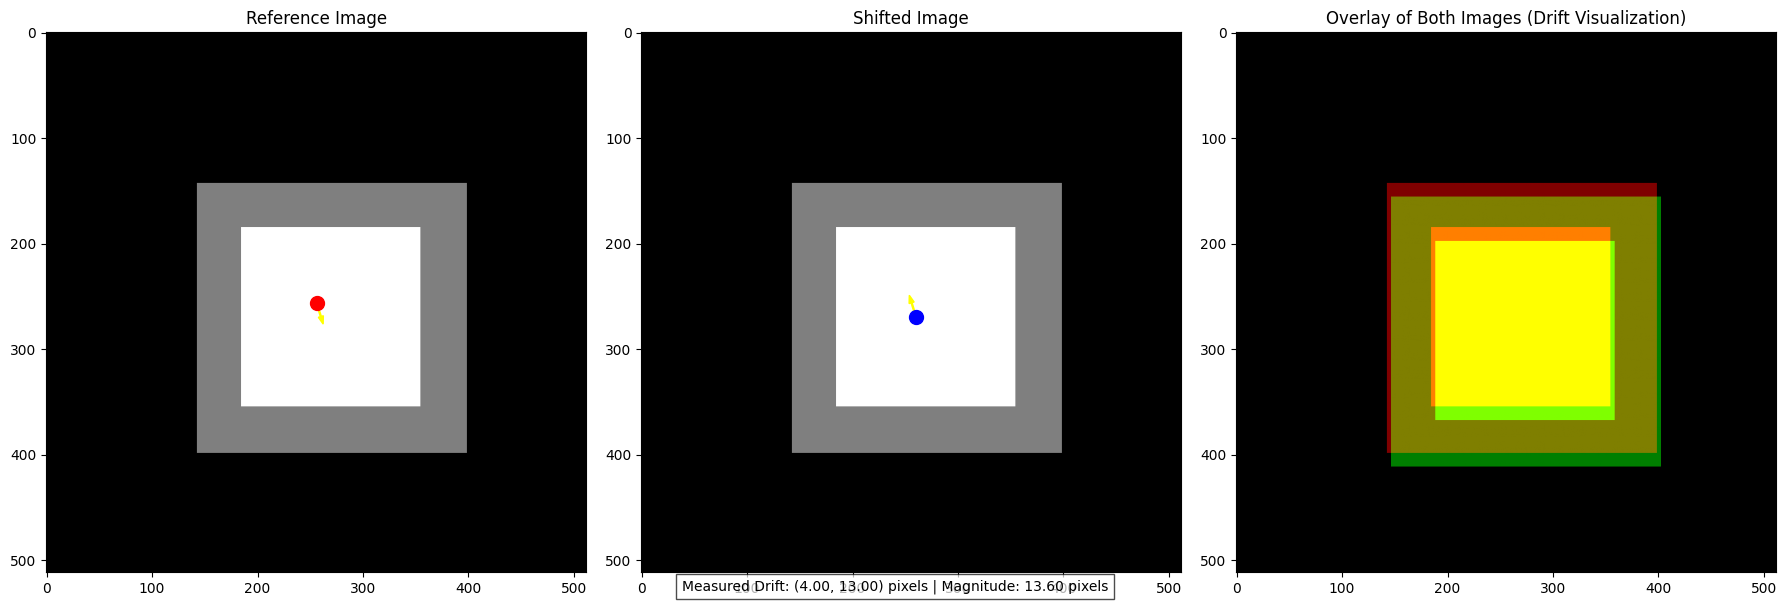

In [29]:
from stemOrchestrator.process import compute_drift, plot_drift_comparison, tiff_to_numpy
haadf_np_array_old, haadf_np_array_shifted = haadf_np_array_old, haadf_np_array_new
image1, image2 = haadf_np_array_old, haadf_np_array_shifted
shift_x, shift_y = compute_drift(image1.T, image2.T)
print(shift_x, shift_y)
fig = plot_drift_comparison(image1, image1, shift_x, shift_y)



## 5. Use pixel size and shift to compute:
- delta_x
- delta_y

In [30]:
# compute delta x and delta y
delta_x = pixel_size_tuple[0]*shift_x
delta_y = pixel_size_tuple[1]*shift_y
print(delta_x, delta_y)
old_x, old_y = tf_acquisition.query_beam_shift_position()
print(old_x, old_y)

2025-03-26 16:25:32,393 - INFO - Request to query the beam(not paused beam) position
2025-03-26 16:25:32,402 - INFO - Done to query the beam(not paused beam) position: at Point(x=3.9408866e-09, y=-1.5763546e-08)


5.254515489383493e-09 1.7077175340496353e-08
3.94088661703762e-09 -1.576354646815048e-08


## 6. Move the beam - Beam_shift([delta_x, delta_y])

In [ ]:
tf_acquisition.move_beam_shift_positon([old_x + delta_x, old_y +  delta_y])

In [ ]:
tf_acquisition.query_beam_shift_position()

In [ ]:
#reset beam shift to 0 by: 
tf_acquisition.move_beam_shift_positon([0, 0])